In [1]:
import os
import mne
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [23]:
# load the data
data_path = os.getcwd()
raw_fname = data_path + '/moeed/data/B0301T.gdf'

raw = mne.io.read_raw_gdf(raw_fname, preload=True)

Extracting EDF parameters from D:\Box\Programs\PythonProjects\mne_examples\moeed\data\B0301T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


D:\Box\Programs\Anaconda\lib\site-packages\mne\io\edf\edf.py:1000: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]


In [24]:
# print some information about the data
# https://mne.tools/stable/auto_tutorials/intro/plot_30_info.html#sphx-glr-auto-tutorials-intro-plot-30-info-py
print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 100.0 Hz
 lowpass: 0.5 Hz
 meas_date: 2005-11-02 15:37:16 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>


In [25]:
# examine the annotations within the file
# https://mne.tools/stable/auto_tutorials/intro/plot_20_events_from_raw.html#sphx-glr-auto-tutorials-intro-plot-20-events-from-raw-py
print(set(raw.annotations.duration))  # set returns unique elements from a list
print(set(raw.annotations.description))

{1.252, 8.0, 15.0, 0.004, 60.0}
{'1078', '277', '1023', '1079', '768', '276', '769', '1081', '770', '1077', '32766'}


<pre>
According to the corresponding document (http://www.bbci.de/competition/iv/desc_2b.pdf), the event types are:

32766   Start of a new run            0.004s
276     Idling EEG (eyes open)        60s
277     Idling EEG (eyes closed)      60s
1081    Eye blinks                    15s
1079    Eye rotation                  15s
1078    Vertical eye movement         15s
1077    Horizontal eye movement       15s
768     Start of a trial              8s
769     Cue onset left (class 1)      1.252s
770     Cue onset right (class 2)     1.252s
781     BCI feedback (continuous)
783     Cue unknown
1023    Rejected trial
</pre>

In [26]:
# for data epoching, we need to convert annotations to events
events, event_dict = mne.events_from_annotations(raw)
print(event_dict)
print(events[:5])  # first column is time step in samples, second doesn't matter, third is code

Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
{'1023': 1, '1077': 2, '1078': 3, '1079': 4, '1081': 5, '276': 6, '277': 7, '32766': 8, '768': 9, '769': 10, '770': 11}
[[    0     0     8]
 [  499     0     6]
 [16749     0     7]
 [32999     0     5]
 [37999     0     4]]


In [27]:
# since "Cue onset left" maps to 10 and "Cue onset right" maps to 11 in the dictionary, we define:
event_id = {'left': 10, 'right': 11}
# looking at the trial timings, we also define the motor imagery window as following:
tmin = 1
tmax = 4

epochs = mne.Epochs(raw, events, event_id, tmin-1, tmax, baseline=None, preload=True, picks = [0, 1, 2])

120 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 120 events and 1001 original time points ...
0 bad epochs dropped


Not setting metadata
Applying baseline correction (mode: percent)


<IPython.core.display.Javascript object>


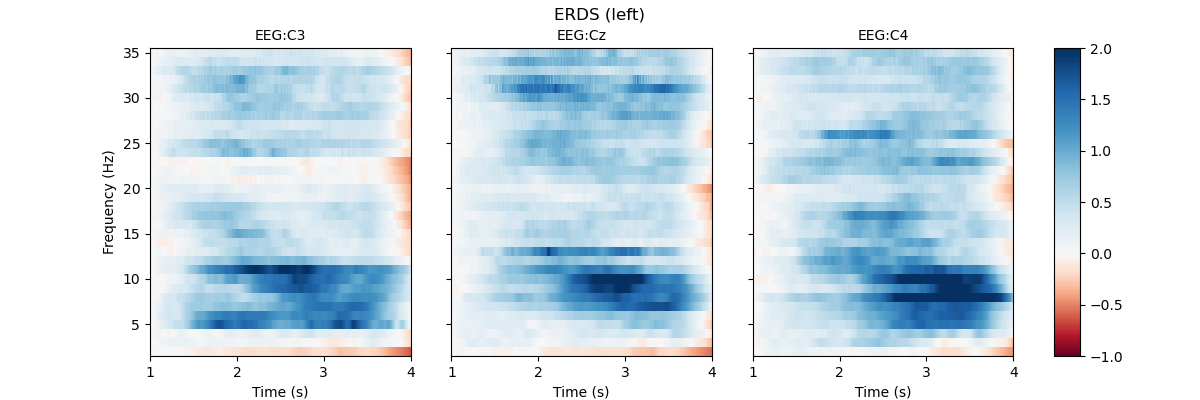

No baseline correction applied
No baseline correction applied
No baseline correction applied


<IPython.core.display.Javascript object>


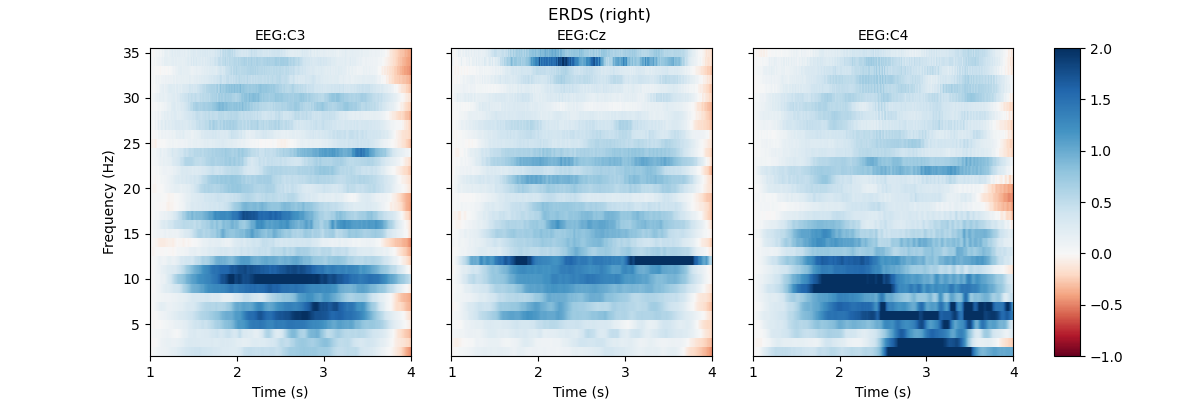

No baseline correction applied
No baseline correction applied
No baseline correction applied


In [28]:
# Visualize epoch spectra
freqs = np.arange(2,36)
vmin, vmax = -1, 2  # set min and max ERDS values in plot
baseline = [0, 1]  # baseline interval (in s)
cmap = mne.viz.utils.center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
# Run TF decomposition overall epochs
tfr = mne.time_frequency.tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs,
                                        use_fft=True, return_itc=False, average=False)
tfr.crop(tmin, tmax)
tfr.apply_baseline(baseline, mode="percent")

for event in event_id:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False)

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if not ax.is_first_col():
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))
    fig.show()